In [18]:
%pip install opencv-python numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
import os
import cv2  # OpenCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Agar grafik muncul di notebook
%matplotlib inline

print("Library berhasil di-import!")

#end

Library berhasil di-import!


In [20]:
# --- KONFIGURASI ---
DATASET_PATH = "dataset wajah2" # Pastikan path ini benar sesuai folder Anda (Dataset_Wajah atau dataset wajah2)
IMG_SIZE = 160  # Sesuai Janji di Laporan Bab 3.3

def load_dataset(path):
    data = []
    labels = []
    class_names = []
    
    # Cek folder
    if not os.path.exists(path):
        print(f"Error: Folder '{path}' tidak ditemukan!")
        print("Tips: Cek sidebar kiri VS Code, apa nama folder sebenarnya? (Huruf besar/kecil berpengaruh)")
        return np.array(data), np.array(labels), class_names

    print(f"Sedang memeriksa folder: {path} ...")

    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        if os.path.isdir(folder_path):
            class_names.append(folder_name)
            label_index = class_names.index(folder_name)
            print(f"--> Memproses kelas: {folder_name}")

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                try:
                    # 1. Baca Citra
                    img_array = cv2.imread(img_path)
                    if img_array is None: continue 

                    # 2. Grayscaling (Sesuai Laporan)
                    gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

                    # 3. Resizing (SUDAH AKTIF KEMBALI - SESUAI LAPORAN)
                    # Kita gunakan IMG_SIZE yang sudah di-set 64 di paling atas
                    resized_img = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE))

                    data.append(resized_img)
                    labels.append(label_index)

                except Exception as e:
                    pass

    data = np.array(data)
    labels = np.array(labels)
    
    print(f"\nSelesai! Total Data: {len(data)} citra.")
    
    # Validasi output untuk memastikan resize berhasil
    if len(data) > 0:
        print(f"Dimensi Citra: {data.shape[1]}x{data.shape[2]} (Sesuai Laporan)")
    
    return data, labels, class_names

# --- EKSEKUSI ---
data, labels, class_names = load_dataset(DATASET_PATH)

if len(data) > 0:
    print("Dataset siap digunakan untuk Training!")

Sedang memeriksa folder: dataset wajah2 ...
--> Memproses kelas: Brad Pitt
--> Memproses kelas: Camila Cabello
--> Memproses kelas: Claire Holt
--> Memproses kelas: Courtney Cox
--> Memproses kelas: Dwayne Johnson
--> Memproses kelas: Ellen Degeneres
--> Memproses kelas: Jessica Alba
--> Memproses kelas: Lisa Kudrow
--> Memproses kelas: Muhammad Al Qarnie

Selesai! Total Data: 450 citra.
Dimensi Citra: 160x160 (Sesuai Laporan)
Dataset siap digunakan untuk Training!


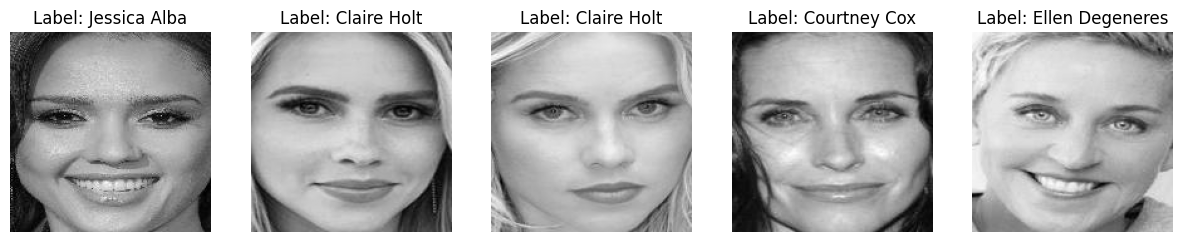

In [21]:
# Menampilkan 5 sampel acak
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, len(data))
    plt.subplot(1, 5, i+1)
    plt.imshow(data[idx], cmap='gray')
    plt.title(f"Label: {class_names[labels[idx]]}")
    plt.axis('off')
plt.show()

#end

In [22]:
# 1. Flattening: Mengubah (N, 64, 64) menjadi (N, 4096)
X = data.reshape(len(data), -1) # -1 otomatis menghitung 64*64
y = labels

print(f"Dimensi Data Sebelum Flatten: {data.shape}")
print(f"Dimensi Data Setelah Flatten: {X.shape} (Siap untuk KNN)")

# 2. Split Data (80% Latih, 20% Uji) - Skenario 2 Bab 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah Data Latih: {len(X_train)}")
print(f"Jumlah Data Uji: {len(X_test)}")

#end

Dimensi Data Sebelum Flatten: (450, 160, 160)
Dimensi Data Setelah Flatten: (450, 25600) (Siap untuk KNN)
Jumlah Data Latih: 360
Jumlah Data Uji: 90


Mulai Pengujian Nilai K...
------------------------------
|  Nilai K  |  Akurasi (80:20)  |
------------------------------
|    K=1    |     71.11%     |
|    K=3    |     65.56%     |
|    K=5    |     71.11%     |
|    K=7    |     67.78%     |
|    K=9    |     73.33%     |
------------------------------


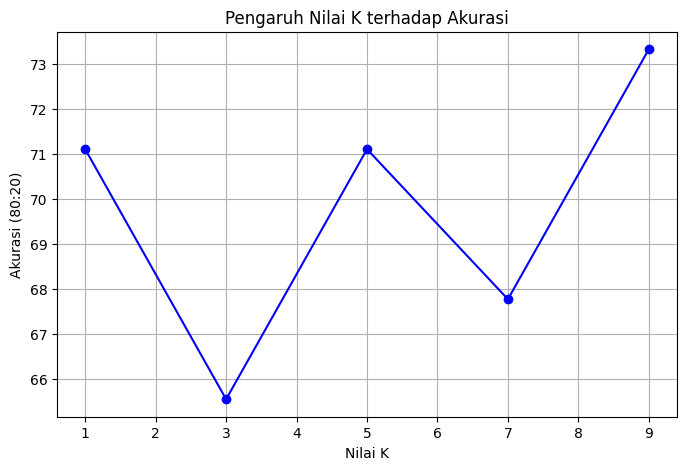

In [23]:
k_values = [1, 3, 5, 7, 9]
accuracies = []

print("Mulai Pengujian Nilai K...")
print("-" * 30)
print("|  Nilai K  |  Akurasi (80:20)  |")
print("-" * 30)

for k in k_values:
    # Membuat model KNN
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

    # Melatih model
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred) * 100
    accuracies.append(acc)

    print(f"|    K={k}    |     {acc:.2f}%     |")

print("-" * 30)

# Visualisasi Grafik (Elbow Method sederhana)
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Pengaruh Nilai K terhadap Akurasi')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (80:20)')
plt.grid(True)
plt.show()


#end


--- Laporan Klasifikasi (K=9) ---
                    precision    recall  f1-score   support

         Brad Pitt       0.50      0.80      0.62        10
    Camila Cabello       1.00      0.80      0.89        10
       Claire Holt       0.73      0.80      0.76        10
      Courtney Cox       0.86      0.60      0.71        10
    Dwayne Johnson       0.88      0.70      0.78        10
   Ellen Degeneres       0.62      0.50      0.56        10
      Jessica Alba       0.67      0.80      0.73        10
       Lisa Kudrow       0.60      0.60      0.60        10
Muhammad Al Qarnie       1.00      1.00      1.00        10

          accuracy                           0.73        90
         macro avg       0.76      0.73      0.74        90
      weighted avg       0.76      0.73      0.74        90



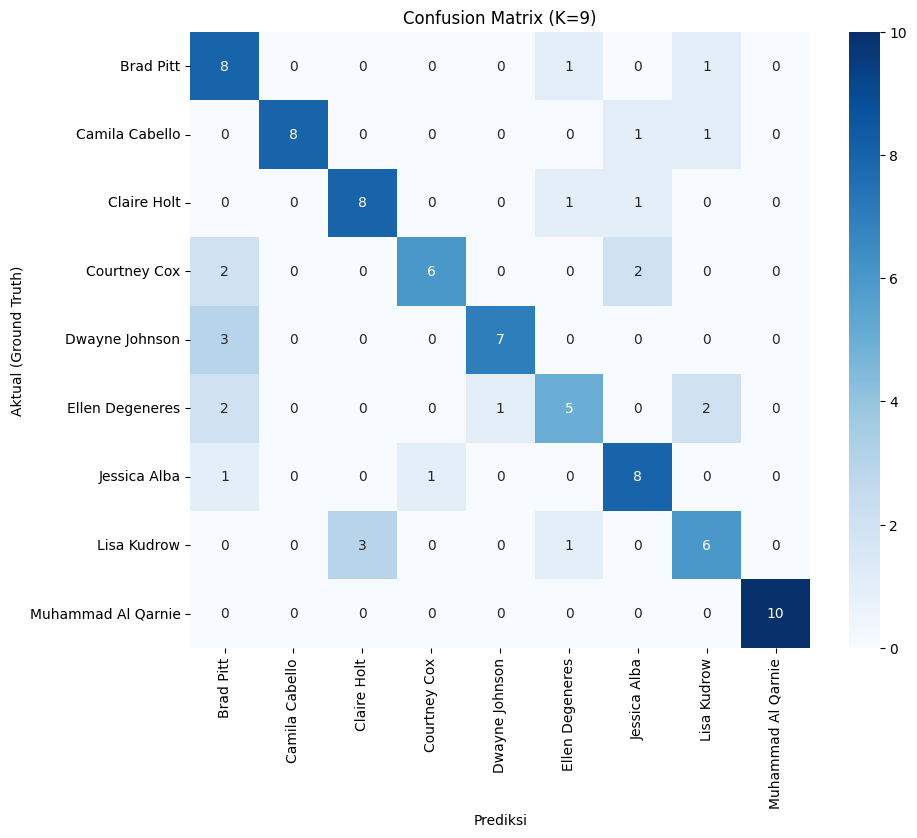

In [24]:
# Ambil K terbaik (misal K=3 berdasarkan grafik di atas)
BEST_K = 9
final_model = KNeighborsClassifier(n_neighbors=BEST_K, metric='euclidean')
final_model.fit(X_train, y_train)

# Prediksi Akhir
y_pred_final = final_model.predict(X_test)

# --- 1. CLASSIFICATION REPORT (Presisi, Recall, F1) ---
print(f"\n--- Laporan Klasifikasi (K={BEST_K}) ---")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# --- 2. CONFUSION MATRIX (Gambar 4.1 di Laporan) ---
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual (Ground Truth)')
plt.title(f'Confusion Matrix (K={BEST_K})')
plt.show()

#end

Jarak terdekat: 5564.38
Sistem: Wajah Dikenali sebagai Lisa Kudrow


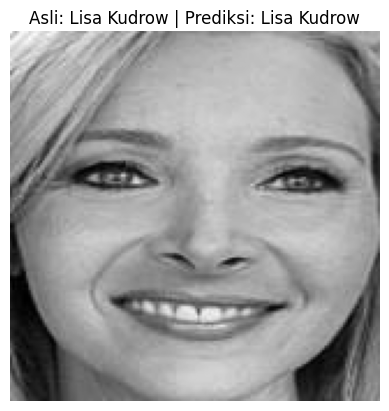

In [25]:
def simulasi_absensi(index_test):
    # Ambil satu gambar dari data uji
    img_test = X_test[index_test].reshape(1, -1) # Flatten ulang
    actual_label = class_names[y_test[index_test]]

    # Cari jarak ke tetangga terdekat (Logika Threshold di Flowchart)
    distances, indices = final_model.kneighbors(img_test)
    min_distance = distances[0][0] # Jarak terdekat

    # Tentukan Threshold (Misal 2000, sesuaikan dengan percobaan)
    THRESHOLD = 10000 # Angka ini harus disesuaikan saat run program
    
    print(f"Jarak terdekat: {min_distance:.2f}")

    if min_distance > THRESHOLD:
        print("Sistem: Wajah TIDAK Dikenali (Jarak terlalu jauh)")
        pred_label = "Unknown"
    else:
        pred_index = final_model.predict(img_test)[0]
        pred_label = class_names[pred_index]
        print(f"Sistem: Wajah Dikenali sebagai {pred_label}")

    # Tampilkan Gambar
    plt.imshow(X_test[index_test].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Asli: {actual_label} | Prediksi: {pred_label}")
    plt.axis('off')
    plt.show()

# Coba simulasi pada data ke-10 di set pengujian
simulasi_absensi(3)

#end

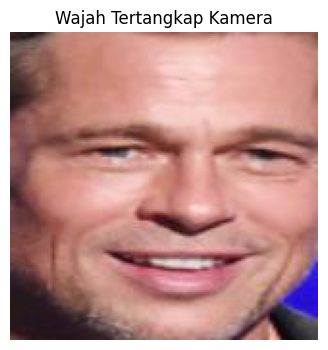


--- HASIL ANALISIS SISTEM ---
Jarak Kemiripan: 6041.10
🟢 Status: ABSEN BERHASIL!
👤 Identitas: Brad Pitt


In [26]:
# --- SIMULASI ABSENSI DENGAN FOTO EKSTERNAL (REAL-WORLD TEST) ---

def tes_foto_baru(path_file_gambar):
    """
    Fungsi ini mensimulasikan kamera menangkap wajah seseorang.
    Kita ambil file gambar dari luar dataset, lalu suruh AI menebak.
    """
    
    # 1. Cek apakah file ada
    if not os.path.exists(path_file_gambar):
        print(f"Error: File '{path_file_gambar}' tidak ditemukan!")
        return

    # 2. Baca Gambar
    img_real = cv2.imread(path_file_gambar)
    if img_real is None:
        print("Error: Gambar tidak bisa dibaca.")
        return
    
    # Tampilkan Gambar Asli
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    plt.title("Wajah Tertangkap Kamera")
    plt.axis('off')
    plt.show()

    try:
        # 3. Pra-pemrosesan (Harus SAMA PERSIS dengan Training)
        # a. Grayscale
        gray_new = cv2.cvtColor(img_real, cv2.COLOR_BGR2GRAY)
        
        # b. Resize (WAJIB 160x160 sesuai model Anda)
        resized_new = cv2.resize(gray_new, (IMG_SIZE, IMG_SIZE))
        
        # c. Flatten (Jadi 1 baris)
        flat_new = resized_new.reshape(1, -1)

        # 4. Prediksi (KNN Magic)
        distances, indices = final_model.kneighbors(flat_new)
        min_dist = distances[0][0]
        
        # 5. Logika Absensi (Threshold)
        # Ingat: Karena size 160x160, jaraknya bakal besar (ribuan/puluhan ribu)
        # Sesuaikan THRESHOLD ini saat demo sampai pas.
        THRESHOLD_DEMO = 25000 
        
        print(f"\n--- HASIL ANALISIS SISTEM ---")
        print(f"Jarak Kemiripan: {min_dist:.2f}")
        
        if min_dist > THRESHOLD_DEMO:
            print("🔴 Status: WAJAH TIDAK DIKENALI (Orang Asing / Bukan Mahasiswa)")
        else:
            pred_index = final_model.predict(flat_new)[0]
            nama_prediksi = class_names[pred_index]
            print(f"🟢 Status: ABSEN BERHASIL!")
            print(f"👤 Identitas: {nama_prediksi}")
            
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# --- CARA PAKAI SAAT DEMO ---
# 1. Siapkan 1 foto wajah teman (misal 'tes_wajah.jpg') di folder yang sama dengan kode ini.
# 2. Panggil fungsinya:
tes_foto_baru("Brad Pitt_118.jpg")


=== PENGUJIAN RASIO 70:30 ===
Data Latih: 315 citra
Data Uji  : 135 citra
----------------------------------------
|  Nilai K  |  Akurasi (70:30)  |
----------------------------------------
|    K=1    |     65.93%      |
|    K=3    |     65.19%      |
|    K=5    |     67.41%      |
|    K=7    |     69.63%      |
|    K=9    |     69.63%      |
----------------------------------------


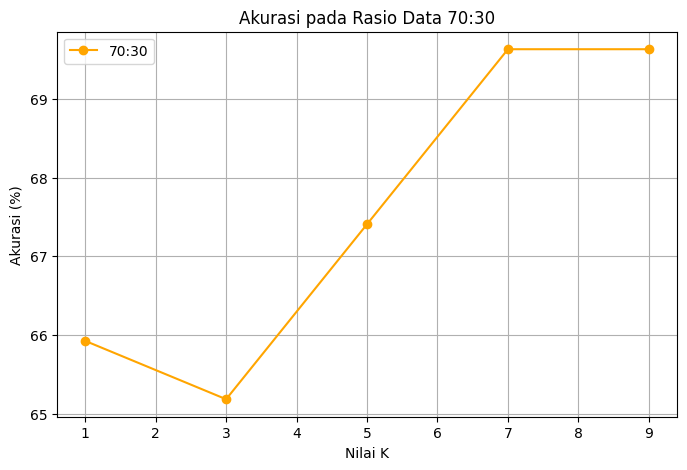

In [27]:
# --- SKENARIO 2.A: PENGUJIAN RASIO 70:30 ---
print("\n=== PENGUJIAN RASIO 70:30 ===")

# 1. Split Data (70% Latih, 30% Uji)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_70)} citra")
print(f"Data Uji  : {len(X_test_30)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_70 = [] # List untuk menyimpan nilai akurasi agar bisa di-plot

print("-" * 40)
print("|  Nilai K  |  Akurasi (70:30)  |")
print("-" * 40)

for k in k_values:
    model_70 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_70.fit(X_train_70, y_train_70)
    y_pred_70 = model_70.predict(X_test_30)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_30, y_pred_70) * 100
    accuracies_70.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 70:30 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_70, marker='o', linestyle='-', color='orange', label='70:30')
plt.title('Akurasi pada Rasio Data 70:30')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()


=== PENGUJIAN RASIO 90:10 ===
Data Latih: 405 citra
Data Uji  : 45 citra
----------------------------------------
|  Nilai K  |  Akurasi (90:10)  |
----------------------------------------
|    K=1    |     71.11%      |
|    K=3    |     68.89%      |
|    K=5    |     68.89%      |
|    K=7    |     71.11%      |
|    K=9    |     77.78%      |
----------------------------------------


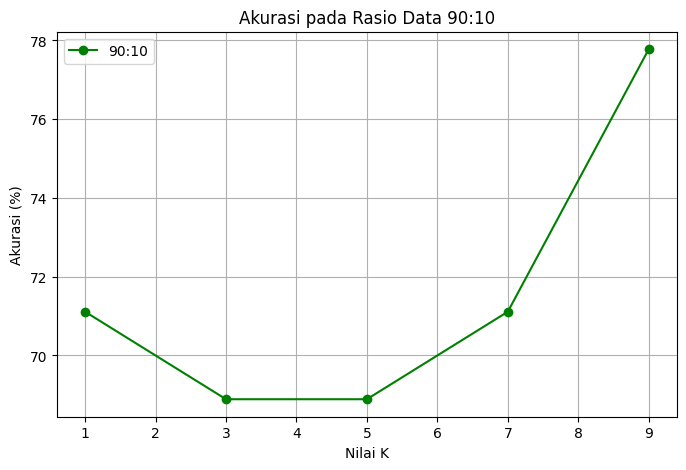

In [28]:
# --- SKENARIO 2.B: PENGUJIAN RASIO 90:10 ---
print("\n=== PENGUJIAN RASIO 90:10 ===")

# 1. Split Data (90% Latih, 10% Uji)
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_90)} citra")
print(f"Data Uji  : {len(X_test_10)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_90 = [] # List wajib ada untuk grafik

print("-" * 40)
print("|  Nilai K  |  Akurasi (90:10)  |")
print("-" * 40)

for k in k_values:
    model_90 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_90.fit(X_train_90, y_train_90)
    y_pred_90 = model_90.predict(X_test_10)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_10, y_pred_90) * 100
    accuracies_90.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 90:10 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_90, marker='o', linestyle='-', color='green', label='90:10')
plt.title('Akurasi pada Rasio Data 90:10')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()

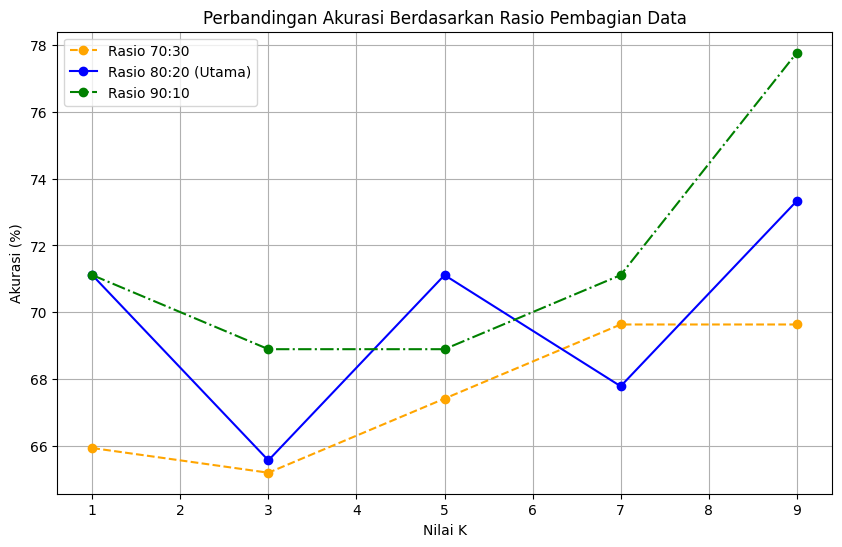

In [29]:
# --- WAJIB ADA BARIS INI DULU ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Ketiga Garis
# Pastikan variabel accuracies_70, accuracies, dan accuracies_90 sudah ada isinya (sudah di-run sebelumnya)
plt.plot(k_values, accuracies_70, marker='o', linestyle='--', color='orange', label='Rasio 70:30')
plt.plot(k_values, accuracies,    marker='o', linestyle='-',  color='blue',   label='Rasio 80:20 (Utama)')
plt.plot(k_values, accuracies_90, marker='o', linestyle='-.', color='green',  label='Rasio 90:10')

plt.title('Perbandingan Akurasi Berdasarkan Rasio Pembagian Data')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
# --- FITUR LENGKAP: ABSENSI REAL-TIME + SIMPAN KE EXCEL (CSV) ---

import cv2
import pandas as pd
from datetime import datetime
import os

# Load Detektor Wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def absen_realtime_dengan_pencatatan():
    print("Membuka Kamera... (Tunggu sebentar)")
    print("Tekan 'q' untuk selesai dan simpan data absen.")
    
    cap = cv2.VideoCapture(0)
    
    # --- VARIABEL UNTUK MENYIMPAN DATA ABSEN ---
    # Set digunakan agar pencarian nama lebih cepat dan mencegah duplikat
    nama_sudah_absen = set() 
    # List digunakan untuk menyimpan detail (Nama, Waktu) untuk Excel
    data_absensi = [] 

    # Tanggal hari ini untuk nama file (misal: Absensi_2025-01-02.csv)
    tanggal_hari_ini = datetime.now().strftime("%Y-%m-%d")
    nama_file_csv = f"Absensi_{tanggal_hari_ini}.csv"

    while True:
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            # Crop & Pre-process
            wajah_crop = gray[y:y+h, x:x+w]
            
            try:
                # Resize & Flatten (Wajib sama dengan training: 160x160)
                wajah_resize = cv2.resize(wajah_crop, (IMG_SIZE, IMG_SIZE))
                wajah_flat = wajah_resize.reshape(1, -1)

                # Prediksi
                distances, indices = final_model.kneighbors(wajah_flat)
                min_dist = distances[0][0]
                
                # Threshold (Sesuaikan jika perlu)
                THRESHOLD_REALTIME = 25000 
                
                if min_dist > THRESHOLD_REALTIME:
                    nama = "Unknown"
                    warna = (0, 0, 255) # Merah
                    status_teks = "Tidak Dikenal"
                else:
                    pred_idx = final_model.predict(wajah_flat)[0]
                    nama = class_names[pred_idx]
                    
                    # --- LOGIKA PENCATATAN ABSEN ---
                    if nama not in nama_sudah_absen:
                        # Jika belum absen, catat waktunya!
                        waktu_sekarang = datetime.now().strftime("%H:%M:%S")
                        nama_sudah_absen.add(nama)
                        data_absensi.append({
                            'Nama': nama,
                            'Waktu Masuk': waktu_sekarang,
                            'Status': 'Hadir'
                        })
                        print(f"[BERHASIL] {nama} tercatat hadir pada pukul {waktu_sekarang}")
                    
                    warna = (0, 255, 0) # Hijau
                    status_teks = "Sudah Absen"

                # Visualisasi Kotak & Nama
                cv2.rectangle(frame, (x, y), (x+w, y+h), warna, 2)
                cv2.putText(frame, f"{nama}", (x, y-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, warna, 2)
                
                # Tambahan: Teks Status di bawah kotak
                if nama != "Unknown":
                    cv2.putText(frame, status_teks, (x, y+h+25), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)

            except Exception as e:
                pass

        # Tampilkan Jumlah yang sudah hadir di pojok kiri atas
        cv2.putText(frame, f"Total Hadir: {len(nama_sudah_absen)}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        cv2.imshow('Sistem Absensi (Tekan q untuk Simpan & Keluar)', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # --- SIMPAN KE FILE EXCEL/CSV ---
    if len(data_absensi) > 0:
        print("\n--- MENYIMPAN DATA ABSENSI ---")
        df = pd.DataFrame(data_absensi)
        
        # Cek jika file sudah ada (append) atau belum (buat baru)
        if os.path.exists(nama_file_csv):
            # Jika file sudah ada, kita tambahkan data baru di bawahnya
            df.to_csv(nama_file_csv, mode='a', header=False, index=False)
            print(f"Data ditambahkan ke file yang sudah ada: {nama_file_csv}")
        else:
            # Buat file baru
            df.to_csv(nama_file_csv, index=False)
            print(f"File baru berhasil dibuat: {nama_file_csv}")
            
        print("Isi Data:")
        print(df)
    else:
        print("Tidak ada data absen yang tersimpan (Belum ada wajah yang dikenali).")

# Jalankan Program
absen_realtime_dengan_pencatatan()

Membuka Kamera... (Tunggu sebentar)
Tekan 'q' untuk selesai dan simpan data absen.
[BERHASIL] Muhammad Al Qarnie tercatat hadir pada pukul 22:42:19
[BERHASIL] Dwayne Johnson tercatat hadir pada pukul 22:42:47
[BERHASIL] Brad Pitt tercatat hadir pada pukul 22:43:25
[BERHASIL] Camila Cabello tercatat hadir pada pukul 22:43:31
[BERHASIL] Ellen Degeneres tercatat hadir pada pukul 22:43:43

--- MENYIMPAN DATA ABSENSI ---
Data ditambahkan ke file yang sudah ada: Absensi_2026-01-01.csv
Isi Data:
                 Nama Waktu Masuk Status
0  Muhammad Al Qarnie    22:42:19  Hadir
1      Dwayne Johnson    22:42:47  Hadir
2           Brad Pitt    22:43:25  Hadir
3      Camila Cabello    22:43:31  Hadir
4     Ellen Degeneres    22:43:43  Hadir


In [ ]:
import cv2
import os
import time

# --- KONFIGURASI ---
DATASET_DIR = "dataset wajah2"  # Folder utama dataset Anda
IMG_SIZE = 160                  # Ukuran wajib (sesuai laporan)
MAX_PHOTOS = 50                 # Target jumlah foto

# Load Detektor Wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def ambil_foto_wajah():
    # 1. Input Nama untuk Folder Baru
    nama_user = input("Masukkan Nama Anda (untuk Label Folder): ").strip()
    
    # Buat folder khusus (misal: dataset wajah2/Garnie)
    save_path = os.path.join(DATASET_DIR, nama_user)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"📂 Folder baru dibuat: {save_path}")
    else:
        print(f"📂 Menggunakan folder yang sudah ada: {save_path}")
        
    # 2. Buka Kamera
    cap = cv2.VideoCapture(0)
    
    print("\n--- INSTRUKSI ---")
    print("1. Arahkan wajah ke kamera.")
    print("2. Tekan tombol 's' (Save) untuk mengambil foto.")
    print("3. Gerakkan wajah sedikit (kiri, kanan, senyum) agar data variatif!")
    print("4. Tekan 'q' jika ingin berhenti paksa.\n")
    
    count = 0
    
    while count < MAX_PHOTOS:
        ret, frame = cap.read()
        if not ret: break
        
        # Copy frame untuk visualisasi (agar kotak tidak ikut tersimpan)
        display_frame = frame.copy()
        
        # Deteksi Wajah
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
        
        for (x, y, w, h) in faces:
            # Gambar kotak di layar preview saja
            cv2.rectangle(display_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Siapkan calon file gambar (Crop Wajah)
            wajah_crop = gray[y:y+h, x:x+w]
            wajah_resize = cv2.resize(wajah_crop, (IMG_SIZE, IMG_SIZE))
        
        # Tampilkan status jumlah foto
        cv2.putText(display_frame, f"Foto: {count}/{MAX_PHOTOS}", (10, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        
        cv2.imshow("Ambil Data Wajah (Tekan 's' untuk simpan)", display_frame)
        
        # Input Keyboard
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('s'):
            # Cek apakah ada wajah terdeteksi sebelum simpan
            if len(faces) > 0:
                # Simpan File
                filename = f"{nama_user}_{count+1}.jpg"
                file_path = os.path.join(save_path, filename)
                cv2.imwrite(file_path, wajah_resize) # Simpan versi grayscale & resize
                
                count += 1
                print(f"📸 Tersimpan ({count}/{MAX_PHOTOS}): {filename}")
                time.sleep(0.2) # Jeda sedikit biar gak double click
            else:
                print("⚠️ Wajah tidak terdeteksi! Dekatkan wajah ke kamera.")
                
        elif key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
    if count >= MAX_PHOTOS:
        print(f"\n✅ SUKSES! 50 Foto wajah {nama_user} berhasil disimpan.")
        print("Silakan Run ulang bagian 'Load Dataset' & 'Training' agar data ini masuk.")

# Jalankan Fungsi
ambil_foto_wajah()

📂 Menggunakan folder yang sudah ada: dataset wajah2\

--- INSTRUKSI ---
1. Arahkan wajah ke kamera.
2. Tekan tombol 's' (Save) untuk mengambil foto.
3. Gerakkan wajah sedikit (kiri, kanan, senyum) agar data variatif!
4. Tekan 'q' jika ingin berhenti paksa.

